<div class='bar_title'></div>

*Decision Support Systems*

# Headline

student1, student2, student3, student,4 <br>

Winter Semester 19/20

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementation</a></span></li></ul></div>

In [1]:
!pip install pulp
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Implementation

In [2]:
# Create model
m = LpProblem("Wire Winding", sense=pulp.LpMaximize)

In [3]:
# Parameters
demand = {'W0075C': 1400,
          'W0033C': 250,
          'W0005X': 1510,
          'W0007X': 1116
         }

minOrder = {'W0075C': 150,
            'W0033C': 0,
            'W0005X': 0,
            'W0007X': 600
           }

production = {'W0075C': {'material': 33, 'labour': 9.90,'overhead': 23.10},
              'W0033C': {'material': 25, 'labour': 7.50,'overhead': 17.50},
              'W0005X': {'material': 35, 'labour': 10.50,'overhead': 24.50},
              'W0007X': {'material': 75, 'labour': 11.25,'overhead': 63.75}
             }

price = {'W0075C': 100,
         'W0033C': 80,
         'W0005X': 130,
         'W0007X': 175}

maxHours = {'drawing': 4000,
            'extrusion': 4200,
            'winding': 2000,
            'packaging': 2300
           }

portion = {'W0075C': {'drawing': 1, 'extrusion': 1,'winding': 1, 'packaging': 1},
           'W0033C': {'drawing': 2, 'extrusion': 1,'winding': 3, 'packaging': 0},
           'W0005X': {'drawing': 0, 'extrusion': 4,'winding': 0, 'packaging': 3},
           'W0007X': {'drawing': 1, 'extrusion': 1,'winding': 0, 'packaging': 2}
             }


In [4]:
# Variables
x = LpVariable.dicts("wire windings", production, lowBound=0, cat='Continuous')

In [5]:
# Objective
m += lpSum([(price[p]-production[p]['labour']-production[p]['overhead']-production[p]['material']) *
            x[p] for p in production])

In [6]:
# Constraints
for p in production:
    m += x[p] <= demand[p], "{}_demand".format(p)
    m += x[p] >= minOrder[p], "{}_minOrder".format(p)

for c in maxHours:
    m += lpSum([portion[p][c] * x[p] for p in production] ) <= maxHours[c], "{}".format(c)

In [7]:
m

Wire Winding:
MAXIMIZE
60.0*wire_windings_W0005X + 25.0*wire_windings_W0007X + 30.0*wire_windings_W0033C + 34.0*wire_windings_W0075C + 0.0
SUBJECT TO
W0075C_demand: wire_windings_W0075C <= 1400

W0075C_minOrder: wire_windings_W0075C >= 150

W0033C_demand: wire_windings_W0033C <= 250

W0033C_minOrder: wire_windings_W0033C >= 0

W0005X_demand: wire_windings_W0005X <= 1510

W0005X_minOrder: wire_windings_W0005X >= 0

W0007X_demand: wire_windings_W0007X <= 1116

W0007X_minOrder: wire_windings_W0007X >= 600

drawing: wire_windings_W0007X + 2 wire_windings_W0033C + wire_windings_W0075C
 <= 4000

extrusion: 4 wire_windings_W0005X + wire_windings_W0007X
 + wire_windings_W0033C + wire_windings_W0075C <= 4200

winding: 3 wire_windings_W0033C + wire_windings_W0075C <= 2000

packaging: 3 wire_windings_W0005X + 2 wire_windings_W0007X
 + wire_windings_W0075C <= 2300

VARIABLES
wire_windings_W0005X Continuous
wire_windings_W0007X Continuous
wire_windings_W0033C Continuous
wire_windings_W0075C Continu

In [8]:
# Solve problem
m.solve()
print (LpStatus[m.status])
obj1 = value(m.objective)
print (obj1)

Optimal
59900.0


In [9]:
for var in m.variables():
    print(var.name, var.varValue)

wire_windings_W0005X 0.0
wire_windings_W0007X 600.0
wire_windings_W0033C 250.0
wire_windings_W0075C 1100.0


In [10]:
for a in maxHours:
    print("Shadow Price | Slack of %s: %f | %f" %
          (a, m.constraints[a].pi, m.constraints[a].slack))
    
for a in production:
    print("Shadow Price | Slack of %s: %f | %f" %
          (a+'_demand', m.constraints[a+'_demand'].pi, m.constraints[a+'_demand'].slack))
    print("Shadow Price | Slack of %s: %f | %f" %
          (a+'_minOrder', m.constraints[a+'_minOrder'].pi, m.constraints[a+'_minOrder'].slack))


Shadow Price | Slack of drawing: -0.000000 | 1800.000000
Shadow Price | Slack of extrusion: -0.000000 | 2250.000000
Shadow Price | Slack of winding: -0.000000 | 150.000000
Shadow Price | Slack of packaging: 34.000000 | -0.000000
Shadow Price | Slack of W0075C_demand: -0.000000 | 300.000000
Shadow Price | Slack of W0075C_minOrder: -0.000000 | -950.000000
Shadow Price | Slack of W0033C_demand: 30.000000 | -0.000000
Shadow Price | Slack of W0033C_minOrder: -0.000000 | -250.000000
Shadow Price | Slack of W0005X_demand: -0.000000 | 1510.000000
Shadow Price | Slack of W0005X_minOrder: -0.000000 | -0.000000
Shadow Price | Slack of W0007X_demand: -0.000000 | 516.000000
Shadow Price | Slack of W0007X_minOrder: -43.000000 | -0.000000


- No need for workers from the drawing department

In [11]:
for p in production:
    print("Reduced Cost of %s: %f" % (p, x[p].dj))

Reduced Cost of W0075C: 0.000000
Reduced Cost of W0033C: 0.000000
Reduced Cost of W0005X: -42.000000
Reduced Cost of W0007X: 0.000000


- Getting rid of the product would improve profits (Reduced Cost < 0)

In [12]:
departments = {'drawing': {'maxInput': 9999,'scrap': 0},
               'extrusion1': {'maxInput': 20,'scrap': 0},
               'extrusion2': {'maxInput': 10,'scrap': 0},
               'winding': {'maxInput': 45,'scrap': 0.15},
               'inspection1': {'maxInput': 15,'scrap': 0.25},
               'inspection2': {'maxInput': 20,'scrap': 0.25},
               'packaging': {'maxInput': 20,'scrap': 0},
               'storage': {'maxInput': 15,'scrap': 0}
              }

links = [('drawing','extrusion1'),
         ('drawing','extrusion2'),
         ('extrusion1', 'winding'),
         ('extrusion2', 'winding'),
         ('winding','inspection1'),
         ('winding','inspection2'),
         ('inspection1','packaging'),
         ('inspection2','packaging'),
         ('packaging','storage'),
         ('winding','scrap'),
         ('inspection1','scrap'),
         ('inspection2','scrap')
        ]

In [13]:
m2 = LpProblem("Wire Winding", LpMaximize)

In [14]:
# A dictionary of the output variables
x = LpVariable.dicts("x",links,0)

In [15]:
# Create objective function
m2 += x[('packaging','storage')]

In [16]:
for d in departments:
    if d!= 'drawing':
        # Supply > Demand
        m2 += lpSum([x[(i,j)] for (i,j) in links if j==d]) * (1-departments[d]['scrap']) >= lpSum(
            [x[(i,j)] for (i,j) in links if ((i==d) & (j!='scrap'))]), "{}_Out".format(d)
                  
        m2 += lpSum([x[(i,j)] for (i,j) in links if j==d]) * departments[d]['scrap'] == lpSum(
            [x[(i,j)] for (i,j) in links if ((i==d) & (j=='scrap'))]), "{}_Scrap".format(d)
        
        # MaxInput > Demand
        m2 +=departments[d]['maxInput'] >= lpSum([x[(i,j)] for (i,j) in links if j==d]), "{}_In".format(d)

In [17]:
# Optimize

m2.solve()

# Print the status of the solved LP
print("Status = %s" % LpStatus[m2.status])
print(value(m2.objective))

Status = Optimal
15.0


In [18]:
for var in m2.variables():
    print(var.name, var.varValue)

x_('drawing',_'extrusion1') 20.0
x_('drawing',_'extrusion2') 10.0
x_('extrusion1',_'winding') 20.0
x_('extrusion2',_'winding') 10.0
x_('inspection1',_'packaging') 11.25
x_('inspection1',_'scrap') 3.75
x_('inspection2',_'packaging') 3.75
x_('inspection2',_'scrap') 1.25
x_('packaging',_'storage') 15.0
x_('winding',_'inspection1') 15.0
x_('winding',_'inspection2') 5.0
x_('winding',_'scrap') 4.5


In [19]:
for d in departments:
    if d!= 'drawing':
        print("Shadow Price | Slack of %s: %f | %f" %
          (d+'_In', m2.constraints[d+'_In'].pi, m2.constraints[d+'_In'].slack))
        print("Shadow Price | Slack of %s: %f | %f" %
          (d+'_Out', m2.constraints[d+'_Out'].pi, m2.constraints[d+'_Out'].slack))
        print("Shadow Price | Slack of %s: %f | %f" %
          (d+'_Scrap', m2.constraints[d+'_Scrap'].pi, m2.constraints[d+'_Scrap'].slack))

Shadow Price | Slack of extrusion1_In: 0.000000 | -0.000000
Shadow Price | Slack of extrusion1_Out: -0.000000 | -0.000000
Shadow Price | Slack of extrusion1_Scrap: -0.000000 | -0.000000
Shadow Price | Slack of extrusion2_In: 0.000000 | -0.000000
Shadow Price | Slack of extrusion2_Out: -0.000000 | -0.000000
Shadow Price | Slack of extrusion2_Scrap: -0.000000 | -0.000000
Shadow Price | Slack of winding_In: -0.000000 | 15.000000
Shadow Price | Slack of winding_Out: -0.000000 | -5.500000
Shadow Price | Slack of winding_Scrap: -0.000000 | -0.000000
Shadow Price | Slack of inspection1_In: -0.000000 | -0.000000
Shadow Price | Slack of inspection1_Out: -0.000000 | -0.000000
Shadow Price | Slack of inspection1_Scrap: -0.000000 | -0.000000
Shadow Price | Slack of inspection2_In: -0.000000 | 15.000000
Shadow Price | Slack of inspection2_Out: -0.000000 | -0.000000
Shadow Price | Slack of inspection2_Scrap: -0.000000 | -0.000000
Shadow Price | Slack of packaging_In: -0.000000 | 5.000000
Shadow Pric

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

In [58]:
G = nx.Graph()
for (i,j) in links:
    G.add_edge(i, j, r=(x[(i,j)].varValue))

In [59]:
G.edges()

EdgeView([('drawing', 'extrusion1'), ('drawing', 'extrusion2'), ('extrusion1', 'winding'), ('extrusion2', 'winding'), ('winding', 'inspection1'), ('winding', 'inspection2'), ('winding', 'scrap'), ('inspection1', 'packaging'), ('inspection1', 'scrap'), ('inspection2', 'packaging'), ('inspection2', 'scrap'), ('packaging', 'storage')])

In [60]:
G.nodes()

NodeView(('drawing', 'extrusion1', 'extrusion2', 'winding', 'inspection1', 'inspection2', 'packaging', 'storage', 'scrap'))

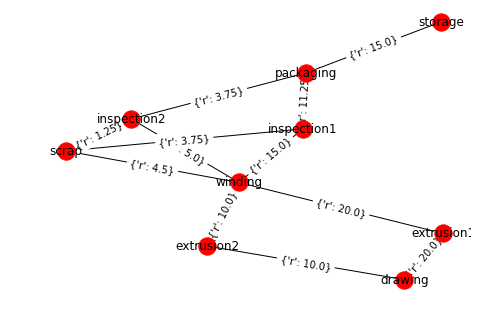

In [69]:
pos = nx.spring_layout(G, scale=2)

edge_labels = nx.get_edge_attributes(G,'r')

nx.draw(G, pos, font_size=12, with_labels=True)

nx.draw_networkx_edge_labels(G, pos=pos, labels = edge_labels)

plt.show()